## Chat Message Memory
- We need to store the historical chat messages in a efficient way
- It wraps another Runnable and manages the chat message history for it.
- Specifically, it loads previous messages in the conversation BEFORE passing it to the Runnable, and it saves the generated response as a message AFTER calling the runnable.
-  This class also enables multiple conversations by saving each conversation with a session_id
- it then expects a `session_id` to be passed in the config when calling the runnable, and uses that to look up the relevant conversation history

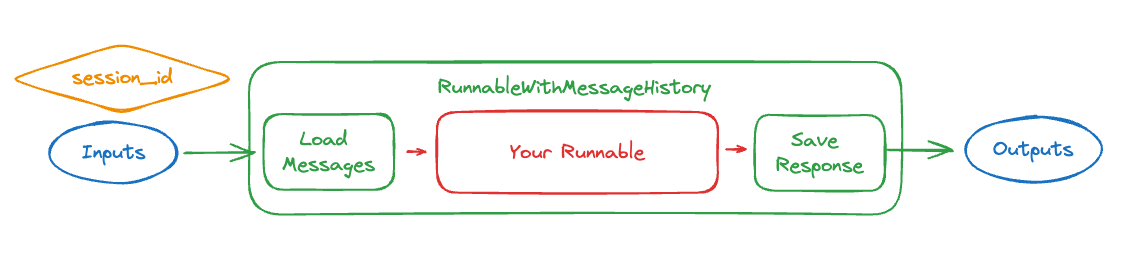

### Simple Chain

In [ ]:
from langchain_ollama import ChatOllama

from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate
                                        )

from langchain_core.output_parsers import StrOutputParser

base_url = "http://localhost:11434"
model = 'llama3.2:3b'

llm = ChatOllama(base_url=base_url, model=model)

template = ChatPromptTemplate.from_template("{prompt}")
chain = template | llm | StrOutputParser()

about = "My name is Laxmi Kant. I work for KGP Talkie."
chain.invoke({'prompt': about})


In [ ]:
prompt = "What is my name?"
chain.invoke({'prompt': prompt})

### Runnable With Message History

In order to properly set this up there are two main things to consider:
- How to store and load messages?
- What is the underlying Runnable you are wrapping and what are its inputs/outputs?


In [3]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables.history import RunnableWithMessageHistory

In [4]:
from langchain_community.chat_message_histories import SQLChatMessageHistory


def get_session_history(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

In [5]:
# one of the simplest ways to get the runnable with history

runnable_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
)

In [ ]:
runnable_with_history.invoke(
    [HumanMessage(content=about)],
    config={"configurable": {"session_id": "laxmikant"}},
)

In [ ]:
runnable_with_history.invoke(
    [HumanMessage(content="whats my name?")],
    config={"configurable": {"session_id": "laxmikant"}},
)

In [ ]:
runnable_with_history.invoke(
    [HumanMessage(content="whats my name?")],
    config={"configurable": {"session_id": "kgptalkie"}},
)

### Message History with Dictionary Like Inputs

In [13]:
from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate,
                                        MessagesPlaceholder
                                        )

In [20]:
system = SystemMessagePromptTemplate.from_template("You are helpful assistant.")
human = HumanMessagePromptTemplate.from_template("{input}")

messages = [system, MessagesPlaceholder(variable_name='histroy'), human]

prompt = ChatPromptTemplate(messages=messages)

chain = prompt | llm  | StrOutputParser()

runnable_with_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
    input_messages_key='input',
    history_messages_key='histroy'
)

In [21]:
def chat_with_llm(session_id, input):
    ouput =  runnable_with_history.invoke(
            {"input": input},
            config={"configurable": {"session_id": session_id}},
        )
    
    return ouput



In [ ]:
chat_with_llm("laxmikant", about)

chat_with_llm("laxmikant", "what is my name?")


In [ ]:
output = chat_with_llm("laxmikant", 'tell me about sun?')
print(output)

In [ ]:
output = chat_with_llm("laxmikant", 'tell me about sun in 3 points only in primary school tone?')
print(output)

In [ ]:
output = chat_with_llm("laxmikant", 'tell me about earth?')
print(output)

In [ ]:
output = chat_with_llm("laxmikant", 'tell me about moon in 2 points only?')
print(output)

In [ ]:
output = chat_with_llm("somethingelse", 'tell me about moon in 2 points only?')
print(output)